In [5]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pickle

import sys
sys.path.append('../py')
from mylib import *
device = "cuda"

In [6]:
#x_train = torch.load('x_train.pt')
#y_train = torch.load('y_train.pt')
#x_train = importPictures()
#y_train = importTargets()
#torch.save(torch.utils.data.TensorDataset(x_train, y_train), 'train_ds.pt')
updateDataSet()

100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


In [30]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()


def fit(epochs, model, loss_func, opt, train_dl, valid_dl = None):
    val_loss = [0] * epochs
    for epoch in (range(epochs)):
        model.train()
        for (xb, yb) in tqdm(train_dl):
            xb , yb = xb.to(device), yb.to(device)
            loss_batch(model, loss_func, xb, yb, opt)
            val_loss[epoch] += loss_batch(model, loss_func, xb, yb, opt)/len(targetPaths)
        print(val_loss[epoch])
        torch.save(model, "model.pt")
    return val_loss

def get_data(train_ds, bs, shuffle = True):
    return(DataLoader(train_ds, batch_size=bs, shuffle=shuffle))

In [4]:
bs = 576
#train_ds = torch.utils.data.TensorDataset(x_train, y_train)
#torch.save(train_ds, 'train_ds.pt')
#del x_train
#del y_train
#del train_ds
#del train_dl
train_dl = get_data(torch.load('train_ds.pt'), bs)

### Model

In [5]:
loss_func = nn.MSELoss()

In [6]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.5)

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.lin1 = nn.Linear(16*32*32, 32*32)
        self.lin64 = nn.Linear(32*32, 32*32)
        self.lin32 = nn.Linear(32*32, 32*16)
        self.lin16 = nn.Linear(32*16, 64)
        self.linf = nn.Linear(64, 1)

        self.int = nn.Linear(1024, 32*32)
    def forward(self, xb):
        xb = torch.tanh(self.conv1(xb))
        xb = torch.tanh(self.conv2(xb))
        xb = torch.tanh(self.conv3(xb))
        #xb = xb.reshape(bs, -1)
        #xb = torch.tanh(self.int(xb))
        xb = torch.tanh(self.lin1(xb.flatten(1)))
        xb = torch.tanh(self.lin64(xb))
        xb = torch.tanh(self.lin64(xb))
        xb = torch.tanh(self.lin64(xb))
        xb = torch.tanh(self.lin32(xb))
        xb = torch.tanh(self.lin16(xb))
        xb = F.relu(self.linf(xb))
        return xb.reshape(-1, 1)


In [10]:
def get_model(model = None):
    if model is None:
        model = SimpleClassifier()
    model = model.to(device)
    return model, torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
model, opt = get_model()

In [12]:
lossplt = fit(2, model, loss_func, opt, train_dl)

100%|██████████| 6615/6615 [05:58<00:00, 18.46it/s]


174.3511627912524


100%|██████████| 6615/6615 [05:28<00:00, 20.12it/s]


110.62085224166535


[174.3511627912524, 110.62085224166535]


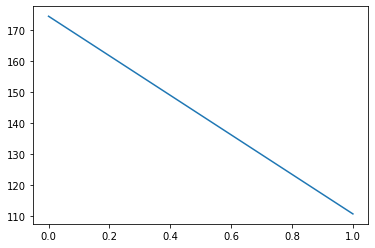

In [13]:
plt.plot(lossplt)
print(lossplt)

In [21]:
id = '005'
img = importPicture("../data/images/mitosis_img_{0}.jpg".format(id))
target = importTarget("../data/images/mitosis_img_{0}.json".format(id))

100%|██████████| 976/976 [00:08<00:00, 119.35it/s]


In [22]:
bs = 576
with torch.no_grad():
    model.eval()
    x_train = partition(img).reshape(-1, 1, 32, 32)
    train_dl = get_data(x_train, bs, False)
    image = torch.empty((len(train_dl), bs, 1))
    for i, x in enumerate(tqdm(train_dl)):
        image[i] = model(x.to(device)).cpu().detach()

100%|██████████| 1323/1323 [00:13<00:00, 94.86it/s]


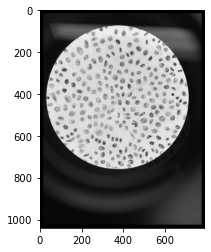

In [23]:
plt.imshow(transforms.ToPILImage()(img), cmap="gray")

torch.Size([1323, 576, 1])
tensor(2.5009)


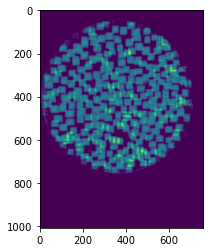

In [24]:
print(image.shape)
print(image.max())
plt.imshow(image.reshape(1008, -1))

torch.Size([1008, 756])


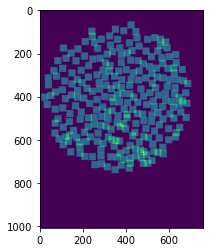

In [25]:
plt.imshow(target)
print(target.shape)

In [26]:
print(cellCount(image))
print(cellCount(target))

tensor(254.9284)
tensor(256.)


In [ ]:
torch.save(model, 'model.pt.old')